In [1]:
library(foreign)
library(nnet)
library(ggplot2)
library(reshape2)

### Examples of multinomial logistic regression

### Description of the data

In [2]:
ml <- read.dta("./datasets/hsbdemo.dta")

In [3]:
with(ml, table(ses, prog))

        prog
ses      general academic vocation
  low         16       19       12
  middle      20       44       31
  high         9       42        7

In [4]:
with(ml, do.call(rbind, tapply(write, prog, function(x) c(M = mean(x), SD = sd(x)))))

,M,SD
general,51.33333,9.397775
academic,56.25714,7.943343
vocation,46.76000,9.318754


### Analysis methods you might consider

### Multinomial logistic regression

In [5]:
ml$prog2 <- relevel(ml$prog, ref = "academic")
test <- multinom(prog2 ~ ses + write, data = ml)

# weights:  15 (8 variable)
initial  value 219.722458 
iter  10 value 179.982880
final  value 179.981726 
converged


In [6]:
summary(test)

Call:
multinom(formula = prog2 ~ ses + write, data = ml)

Coefficients:
         (Intercept)  sesmiddle    seshigh      write
general     2.852198 -0.5332810 -1.1628226 -0.0579287
vocation    5.218260  0.2913859 -0.9826649 -0.1136037

Std. Errors:
         (Intercept) sesmiddle   seshigh      write
general     1.166441 0.4437323 0.5142196 0.02141097
vocation    1.163552 0.4763739 0.5955665 0.02221996

Residual Deviance: 359.9635 
AIC: 375.9635 

In [7]:
z <- summary(test)$coefficients/summary(test)$standard.errors
z

,(Intercept),sesmiddle,seshigh,write
general,2.445214,-1.2018081,-2.261334,-2.705562
vocation,4.484769,0.6116747,-1.649967,-5.112689


In [8]:
# 2-tailed z test
p <- (1 - pnorm(abs(z), 0, 1)) * 2
p

,(Intercept),sesmiddle,seshigh,write
general,0.0144766100,0.2294379,0.02373856,6.818902e-03
vocation,0.0000072993,0.5407530,0.09894976,3.176045e-07


In [9]:
## extract the coefficients from the model and exponentiate
exp(coef(test))

,(Intercept),sesmiddle,seshigh,write
general,17.32582,0.5866769,0.3126026,0.9437172
vocation,184.61262,1.3382809,0.3743123,0.8926116


In [10]:
head(pp <- fitted(test))

academic,general,vocation
0.1482764,0.3382454,0.5134781
0.1202017,0.1806283,0.6991700
0.4186747,0.2368082,0.3445171
0.1726885,0.3508384,0.4764731
0.1001231,0.1689374,0.7309395
0.3533566,0.2377976,0.4088458


In [11]:
dses <- data.frame(ses = c("low", "middle", "high"), write = mean(ml$write))
predict(test, newdata = dses, "probs")

academic,general,vocation
0.4396845,0.3581917,0.2021238
0.4777488,0.2283353,0.2939159
0.7009007,0.1784939,0.1206054


In [12]:
dwrite <- data.frame(ses = rep(c("low", "middle", "high"), each = 41), write = rep(c(30:70), 3))

## store the predicted probabilities for each value of ses and write
pp.write <- cbind(dwrite, predict(test, newdata = dwrite, type = "probs", se = TRUE))

## calculate the mean probabilities within each level of ses
by(pp.write[, 3:5], pp.write$ses, colMeans)

pp.write$ses: high
 academic   general  vocation 
0.6164315 0.1808037 0.2027648 
------------------------------------------------------------ 
pp.write$ses: low
 academic   general  vocation 
0.3972977 0.3278174 0.2748849 
------------------------------------------------------------ 
pp.write$ses: middle
 academic   general  vocation 
0.4256198 0.2010864 0.3732938 

In [13]:
## melt data set to long for ggplot2
lpp <- melt(pp.write, id.vars = c("ses", "write"), value.name = "probability")
head(lpp)  # view first few rows

ses,write,variable,probability
low,30,academic,0.09843588
low,31,academic,0.10716868
low,32,academic,0.11650390
low,33,academic,0.12645834
low,34,academic,0.13704576
low,35,academic,0.14827643


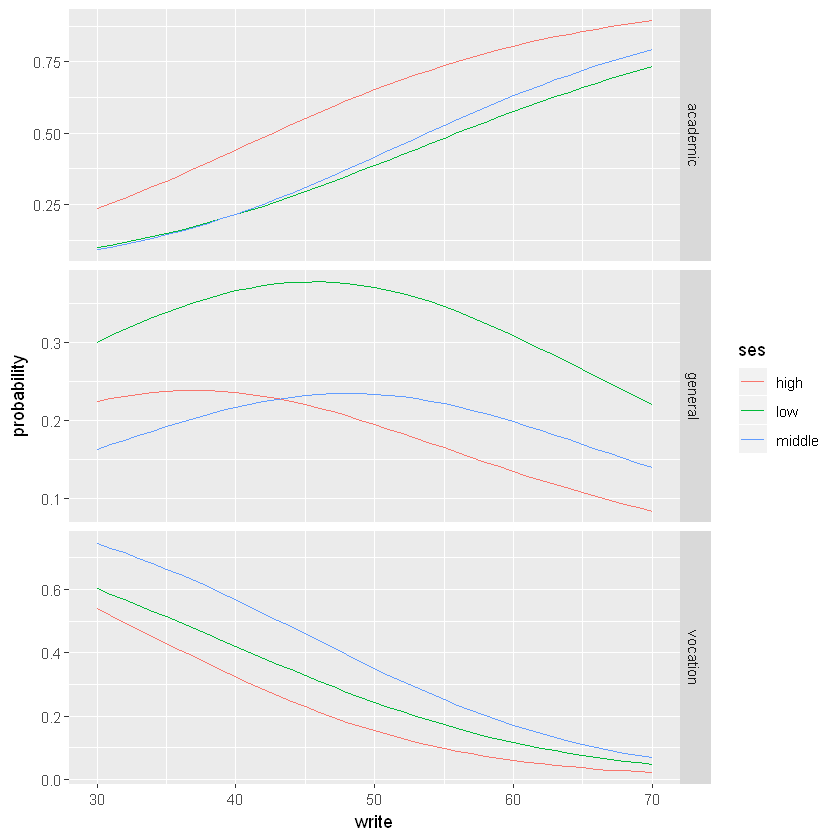

In [14]:
## plot predicted probabilities across write values for each level of ses
## facetted by program type
ggplot(lpp, aes(x = write, y = probability, colour = ses)) + geom_line() + facet_grid(variable ~ ., scales = "free")

### Things to consider